# 🌿 Smart Irrigation Advisor

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import joblib

## Data Loading and EDA

In [2]:
# Load Data
data = pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


### Dataset Overview

In [3]:
# Shape and column types
print("Shape:", data.shape)
print(f"\nData Types:\n{data.dtypes}")

# Check for missing values
print(f"\nMissing Values:\n{data.isnull().sum()}")

# Check for duplicates
print(f"\nDuplicates:\n{data.duplicated().sum()}")

Shape: (2200, 8)

Data Types:
N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

Missing Values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Duplicates:
0


In [4]:
# Basic statistics
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


### Feature Distributions

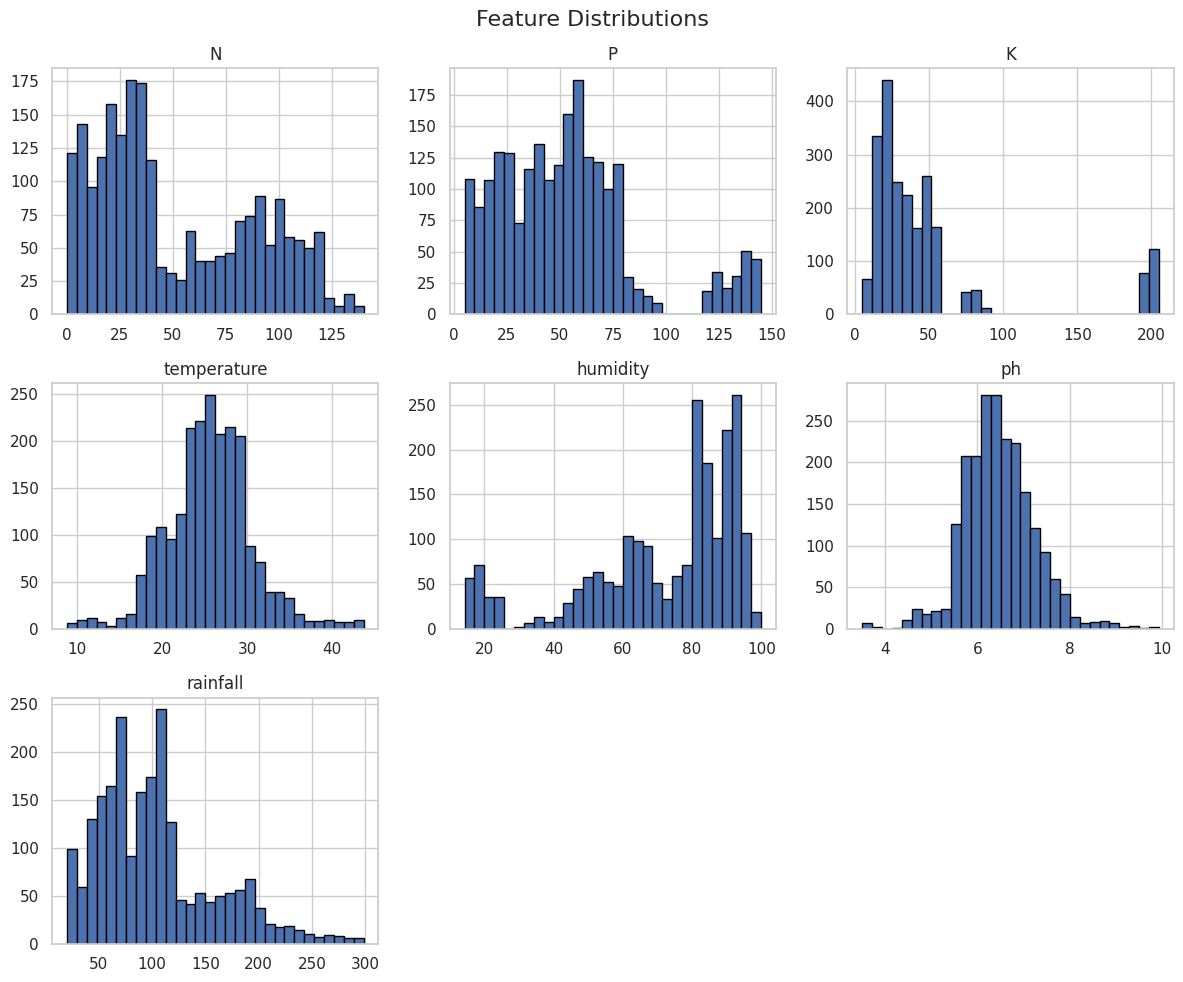

In [5]:
sns.set(style="whitegrid")

data.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

### Correlation Matrix

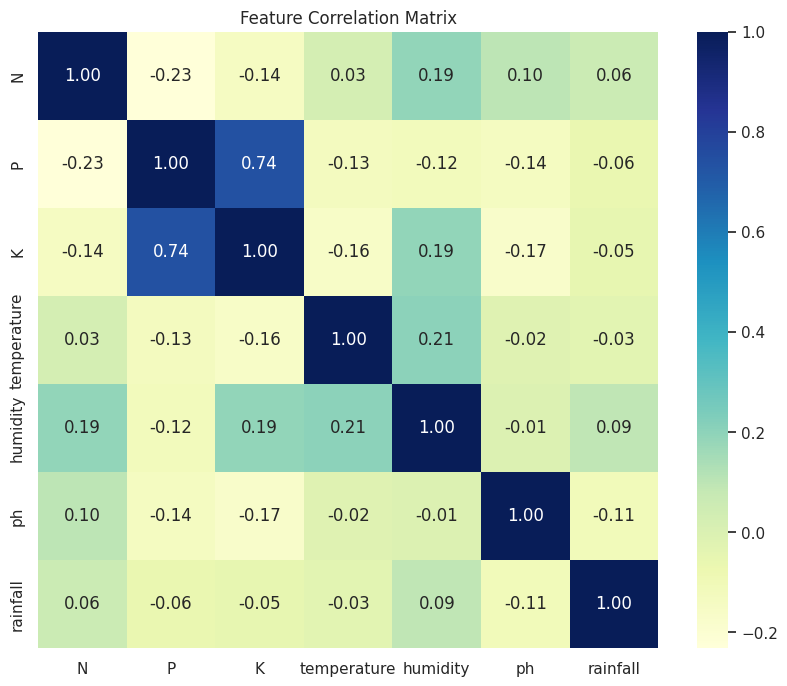

In [6]:
numeric_data = data.drop(columns=["label"])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Crop Count Distribution

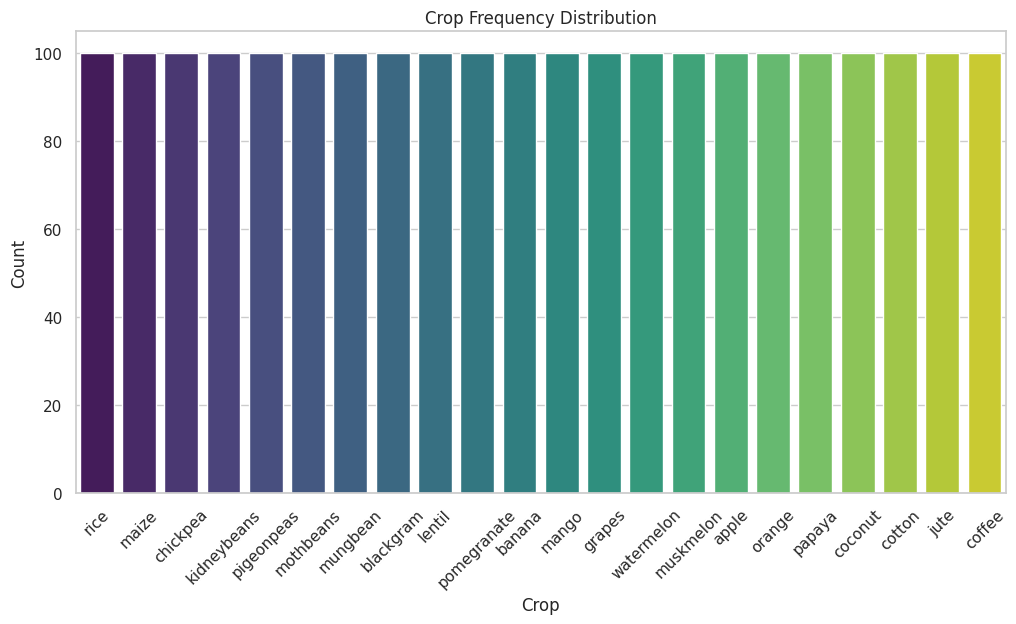

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='label', order=data['label'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Crop Frequency Distribution")
plt.xlabel("Crop")
plt.ylabel("Count")
plt.show()

## Data Preprocessing

In [8]:
# Prepare data
X = data.drop("label", axis=1)
y = data["label"]

In [9]:
# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

##  Stacking Ensemble Model

In [11]:
# Base Learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', C=1.0)))
]

#  Build Stacked Ensemble Model
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

In [12]:
# Train the Model
stacked_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('svc',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [13]:
# Evaluate the model
y_pred = stacked_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

## Save the Model

In [14]:
joblib.dump(stacked_model, "/kaggle/working/smart_irrigation_model.pkl")

['/kaggle/working/smart_irrigation_model.pkl']

In [15]:
joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")

['/kaggle/working/label_encoder.pkl']